# fin_Report

## 0. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch

import re

import warnings
warnings.filterwarnings(action='ignore')

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

seed = 1234
set_seed(seed)

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로를 직접 설정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Hugging Face의 병렬 처리가 비활성화
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# max_len 도출
from typing import List

def calculate_optimal_max_len(lengths: List[int], thresholds=[64, 128, 256, 512], percentile=90) -> int:
    """
    Calculates the optimal max_len based on the specified percentile of the lengths.
    
    Args:
        lengths (List[int]): List of lengths of each text sample.
        thresholds (List[int]): Possible threshold values to choose from.
        percentile (int): The percentile to use as the cutoff for length.

    Returns:
        int: The optimal max_len based on the given percentile.
    """
    # Calculate the length at the specified percentile
    max_len_suggestion = np.percentile(lengths, percentile)
    
    # Find the closest threshold
    optimal_max_len = min(thresholds, key=lambda x: abs(x - max_len_suggestion))
    
    # Plot length distribution and percentile line
    plt.hist(lengths, bins=30, alpha=0.6, color='b', edgecolor='black')
    plt.axvline(max_len_suggestion, color='red', linestyle='--', label=f'{percentile}th percentile = {int(max_len_suggestion)}')
    plt.axvline(optimal_max_len, color='green', linestyle='-', label=f'Chosen max_len = {optimal_max_len}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution with Optimal max_len')
    plt.legend()
    plt.show()
    
    return optimal_max_len

In [6]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity_distance(vector1, vector2, label1="Vector1", label2="Vector2"):

    # 코사인 유사도 및 유클리디안 거리 계산
    similarity_block = cosine_similarity(vector1, vector2)
    euc_distances = euclidean_distances(vector1, vector2)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    # 코사인 유사도 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity_block, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity")
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    # 유클리디안 거리 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(euc_distances, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Euclidean Distance")
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    plt.tight_layout()
    plt.show()


## 1. Load Data

In [51]:
# from datasets import load_dataset

train = pd.read_csv('data/train_data.csv')
valid = pd.read_csv('data/val_data.csv')
test = pd.read_csv('data/test_data.csv')
#test = pd.DataFrame(load_dataset("lbox/lbox_open", "casename_classification",
#                                 download_mode="force_redownload")['test']).drop(columns=['id'])

train['class'] = train['class'].astype('category')
valid['class'] = valid['class'].astype('category')
test['class'] = test['class'].astype('category')

In [52]:
train.head(5)

class                                               text
0     i  2) 또한 자동차 열쇠에 대한 배타적인 점유를 취득하는 이상 인근에 주차된 해당 자...
1     w  자기의 행위로 인하여 타인의 사망이라는 결과를 발생시킬 만한 가능성 또는 위험이 있...
2     u     이 사건의 경우 앞서 든 증거들에 의하여 인정되는 다음과 같은 사정들을 고려하여보면
3     c     나. 피고인은 본건 범행 당시 술에 취하여 심신상실 또는 심신미약의 상태에 있었다.
4     d  ② 피해자가 피고인에게 먼저 시비를 걸며 부엌에 있던 식칼을 꺼내들고 피고인을 위협...

In [11]:
valid.head(5)

class                                               text
0     i    피해자가 입은 상해의 부위 및 정도는 사망에 이를 수 있는 정도의 위험한 수준이었고,
1     c  이 사건 범행 당시 피고인에게 미필적으로나마 살인의 범의가 있었음을 충분히 인정할 ...
2     e      이러한 손상은 둔기에 의해 발생 가능한 손상으로 보인다는 소견을 밝히고 있는 점,
3     c                               피고인 A에게 살인의 고의는 없었고,
4     c  피고인이 이 사건 범행 당시 음주로 인하여 사물을 변별할 능력이나 의사를 결정할 능...

In [88]:
test.head(5)

class                                           text
0     u  이 법원이 적법하게 채택하여 조사한 증거에 의하여 인정되는 아래와 같은 사정 즉,
1     u                               위와 같은 사정들을 모아보면,
2     u      앞서 살핀 증거에 의하여 인정되는 다음과 같은 사실 또는 사정을 종합하면,
3     u                                     피고인과 변호인은,
4     d                                  (증거기록 제178쪽).

In [6]:
train.describe()

class   text
count   4078   4078
unique     8   3832
top        d  살피건대,
freq    1360     11

In [7]:
valid.describe()

class               text
count   1935               1935
unique     8               1852
top        d  위 주장은 받아들이지 아니한다.
freq     687                  6

In [89]:
test.describe()

class                                      text
count    780                                       780
unique     8                                       755
top        d  (대법원 2009. 2. 26. 선고 2008도9867 판결 등 참조).
freq     274                                         4

## 2. Base EDA

In [53]:
def split_columns(df):
    text_columns = df.select_dtypes(include=["object", "string"]).columns.tolist()
    class_columns = df.select_dtypes(include=["int64", "float64", "category"]).columns.tolist()
    return text_columns, class_columns

# 각 데이터셋의 컬럼 나누기
train_text_cols, train_class_cols = split_columns(train)
valid_text_cols, valid_class_cols = split_columns(valid)
test_text_cols, test_class_cols = split_columns(test)

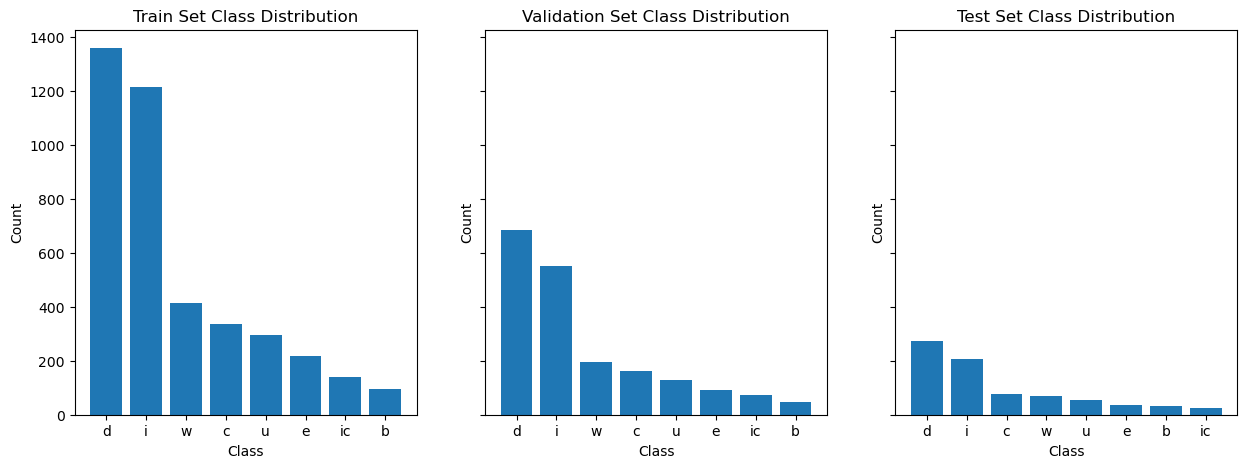

In [112]:
datasets = {"Train": train, "Validation": valid, "Test": test}
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (name, df) in zip(axes, datasets.items()):
    class_col = train_class_cols[0]  # class 컬럼 이름 가져오기
    class_counts = df[class_col].value_counts()
    ax.bar(list(class_counts.index), list(class_counts.values))
    ax.set_title(f'{name} Set Class Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

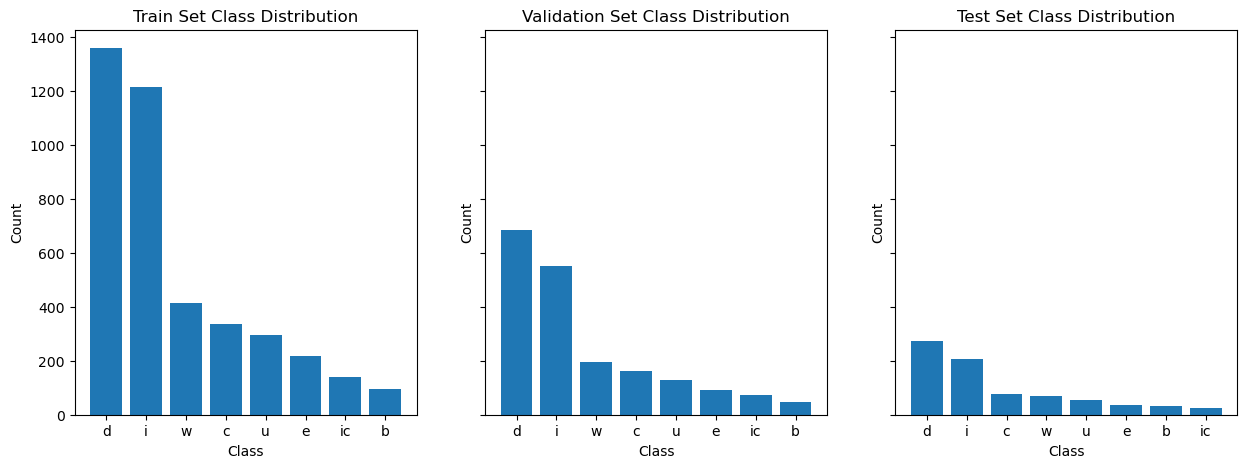

In [110]:
datasets = {"Train": train, "Validation": valid, "Test": test}
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (name, df) in zip(axes, datasets.items()):
    class_counts = pd.DataFrame(df[train_class_cols[0]].value_counts())[train_class_cols[0]]
    ax.bar(list(class_counts.index), list(class_counts.values))
    #ax.bar(class_counts.index, class_counts.values, color="skyblue")
    ax.set_title(f'{name} Set Class Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

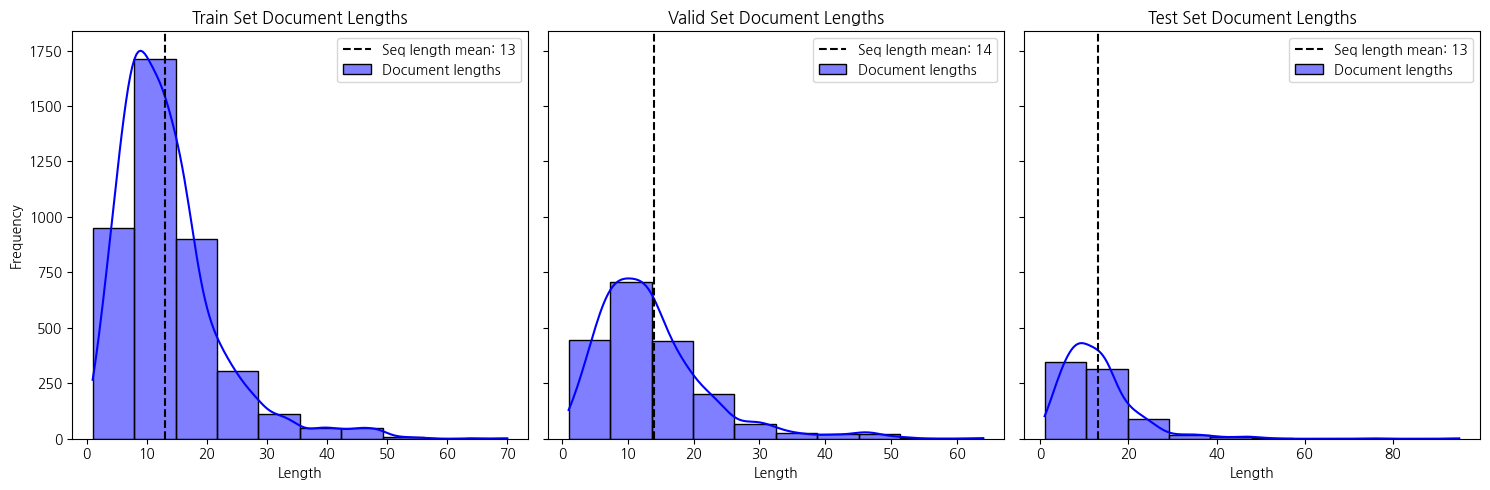

Train Set:
 가장 긴 문장은 70 개의 단어
 가장 짧은 문장은 1 개의 단어

Valid Set:
 가장 긴 문장은 64 개의 단어
 가장 짧은 문장은 1 개의 단어

Test Set:
 가장 긴 문장은 95 개의 단어
 가장 짧은 문장은 1 개의 단어



In [23]:
for name, df in datasets.items():
    df['doc_len'] = df.text.apply(lambda words: len(words.split()))

# 1*3 그래프 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (name, df) in zip(axes, datasets.items()):
    mean_seq_len = np.round(df['doc_len'].mean()).astype(int)
    sns.histplot(df['doc_len'], kde=True, ax=ax, bins=10, label='Document lengths', color='blue')
    ax.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Seq length mean: {mean_seq_len}')
    ax.set_title(f'{name} Set Document Lengths')
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

# 가장 긴/짧은 문장 출력
for name, df in datasets.items():
    print(f"{name} Set:")
    print(f" 가장 긴 문장은 {df['doc_len'].max()} 개의 단어")
    print(f" 가장 짧은 문장은 {df['doc_len'].min()} 개의 단어\n")

In [24]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Okt

# 텍스트 전처리 함수
def clean_text(sent):
    sent_clean = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣ\s]", " ", sent)
    return sent_clean

# Okt 객체 생성
okt = Okt()

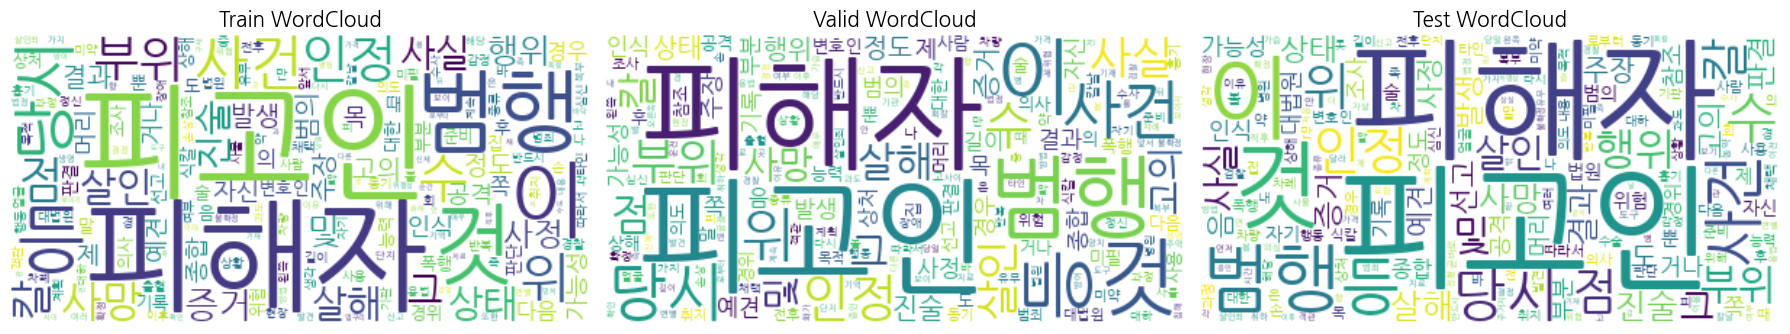

In [25]:
# 1*3 그래프 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (name, df) in zip(axes, datasets.items()):
    # 텍스트 전처리 및 토큰화
    df['cleaned_facts'] = df['text'].apply(lambda x: clean_text(x))
    text_data = df['cleaned_facts'].tolist()
    token_sentences = [okt.nouns(text) for text in text_data]

    # 단어 빈도 계산
    counter = Counter()
    for tokens in token_sentences:
        counter.update(tokens)

    # 워드클라우드 생성
    FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    wc = WordCloud(font_path=FONT_PATH, background_color="white")
    cloud = wc.generate_from_frequencies(counter)
    
    # 플롯에 워드클라우드 시각화
    ax.imshow(cloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{name} WordCloud', fontsize=15)

plt.tight_layout()
plt.show()

## 3. Embedding
Load Model 

In [26]:
# KLUE RoBERTa 모델과 토크나이저 설정
from transformers import AutoModel, AutoTokenizer

model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name).to(device)

2024-11-25 16:13:11.646084: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 16:13:11.647277: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 16:13:11.668081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 16:13:12.042645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bia

In [27]:
from collections import Counter
# 토큰화
tokens = [token for sentence in train["text"] for token in tokenizer.tokenize(sentence)]

# 토큰 빈도 계산
token_counts = Counter(tokens)

# 빈도가 높은 상위 30개 서브워드 출력
print(token_counts.most_common(30))

[('##의', 3605), (',', 3214), ('##을', 2994), ('##에', 2965), ('##이', 2472), ('##는', 2456), ('.', 2328), ('피고인', 2309), ('피해자', 2229), ('##은', 1860), ('##를', 1733), ('있', 1441), ('##고', 1426), ('##가', 1280), ('##하', 1234), ('##다', 1155), ('##한', 1033), ('것', 1020), ('범행', 994), ('##로', 989), ('##었', 968), ('##으로', 927), ('##게', 915), ('이', 824), ('##에서', 722), ('##지', 696), ('등', 665), ('##였', 664), ('##도', 578), ('##과', 574)]


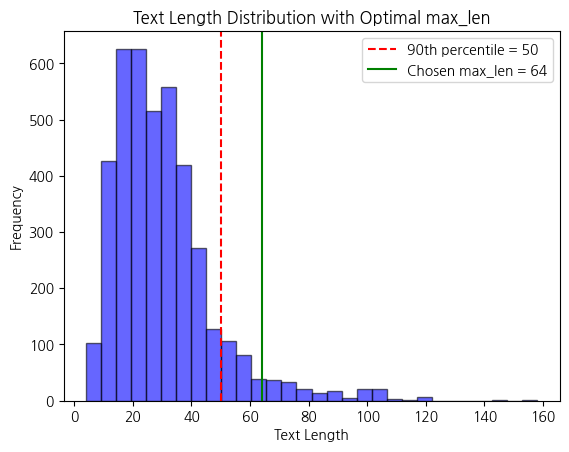

In [28]:
# max_len 길이 구하기
token_lengths = [len(tokenizer.encode(text)) for text in train["text"]]

# 최적의 max_len 계산
max_len = calculate_optimal_max_len(token_lengths)

In [29]:
from torch.utils.data import DataLoader, Dataset

# 1. 커스텀 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.texts = self.data.apply(lambda row: f"{row['class']} {row['text']}", axis=1)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts.iloc[idx]
    
# 2. 데이터셋 준비
train_dataset = CustomDataset(train)
valid_dataset = CustomDataset(valid)
test_dataset = CustomDataset(test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
# 3. 임베딩 생성 함수
def generate_embeddings(data_loader):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩 사용
            embeddings.append(cls_embeddings.cpu())
    return torch.cat(embeddings).numpy()

# 데이터 임베딩 생성
train_embeddings = generate_embeddings(train_loader)
valid_embeddings = generate_embeddings(valid_loader)
test_embeddings = generate_embeddings(test_loader)

In [31]:
train_embeddings[:,]

array([[ 0.11617044, -0.6478726 , -0.12449942, ..., -0.14136426,
        -0.13365233,  0.17427939],
       [ 0.14338897, -0.6692238 , -0.18163085, ..., -0.0593039 ,
        -0.11016992,  0.13832808],
       [ 0.18491174, -0.66291255, -0.19189562, ..., -0.10797028,
        -0.09810009,  0.07542778],
       ...,
       [ 0.10490928, -0.70112723, -0.16174017, ...,  0.01432612,
        -0.1532715 ,  0.12465209],
       [ 0.05359856, -0.60453564, -0.1991503 , ..., -0.00758926,
        -0.1585424 ,  0.18308842],
       [ 0.07093998, -0.6877106 , -0.22110112, ..., -0.07866712,
        -0.13991055,  0.07906697]], dtype=float32)

## 4. visualization

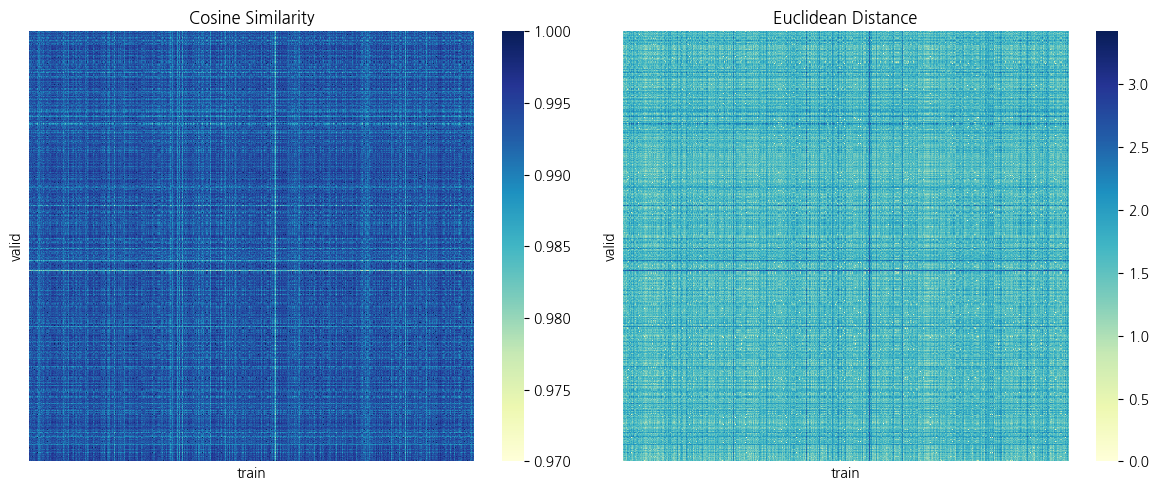

In [20]:
visualize_similarity_distance(train_embeddings, valid_embeddings, 'train', 'valid')

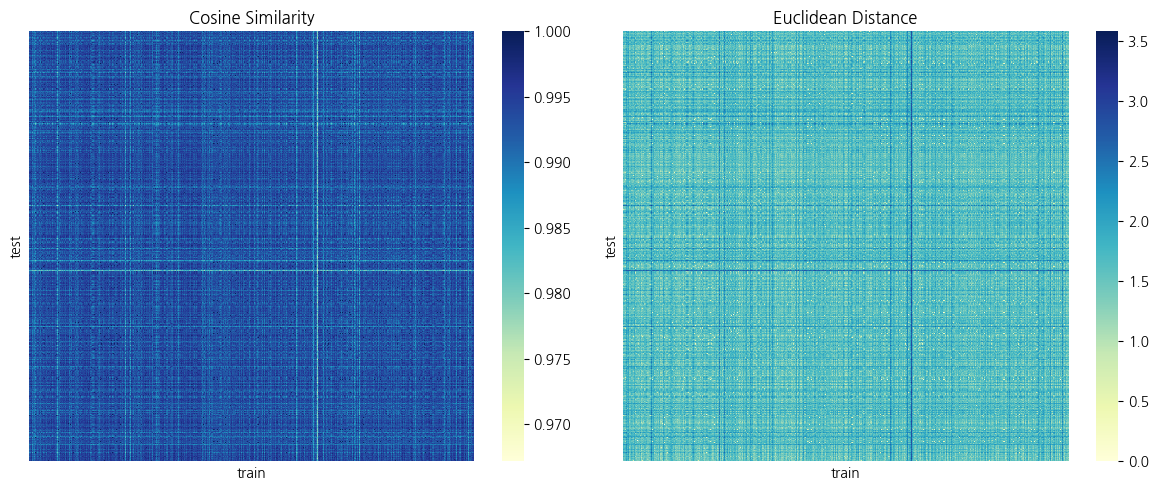

In [21]:
visualize_similarity_distance(train_embeddings, test_embeddings, 'train', 'test')

방향적으로 유사한 형태임을 알 수 있음

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap.umap_ as umap

def umap_density_plot(train_embeddings, test_embeddings, label1="Train", label2="Test"):
    """
    Train과 Test 데이터를 비교하며 UMAP Density Plot을 1x2 서브플롯으로 진행하는 함수.
    - 2D Density Plot
    - 3D Density Plot (Train/Test 구분 강화)

    Args:
        train_embeddings (numpy.ndarray): Train 데이터 임베딩
        test_embeddings (numpy.ndarray): Test 데이터 임베딩
    """
    # Train과 Test 데이터 결합
    embeddings = np.vstack([train_embeddings, test_embeddings])
    labels = ['Train'] * len(train_embeddings) + ['Test'] * len(test_embeddings)

    # UMAP 학습 (2D 및 3D 결과 생성)
    umap_2d_model = umap.UMAP(n_components=2, random_state=42)
    umap_3d_model = umap.UMAP(n_components=3, random_state=42)

    umap_results_2d = umap_2d_model.fit_transform(embeddings)
    umap_results_3d = umap_3d_model.fit_transform(embeddings)

    # 데이터 분리
    x_2d, y_2d = umap_results_2d[:, 0], umap_results_2d[:, 1]
    x_3d, y_3d, z_3d = umap_results_3d[:, 0], umap_results_3d[:, 1], umap_results_3d[:, 2]

    # -------------------------
    # 1x2 서브플롯 생성
    # -------------------------
    fig = plt.figure(figsize=(16, 8))

    # 1. 2D Density Plot
    ax1 = fig.add_subplot(1, 2, 1)
    sns.kdeplot(
        x=x_2d, y=y_2d, hue=labels,
        fill=True, alpha=0.5, palette="viridis", ax=ax1
    )
    ax1.set_title("2D UMAP Density Plot: " + label1 + ' vs ' + label2, fontsize=15)
    ax1.set_xlabel("UMAP Dimension 1")
    ax1.set_ylabel("UMAP Dimension 2")
    ax1.legend(title="Dataset")

    # 2. 3D Scatter Plot (Train/Test 색상 구분)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # Train/Test 각각 다른 색상으로 시각화
    train_idx = [i for i, lbl in enumerate(labels) if lbl == label1]
    test_idx = [i for i, lbl in enumerate(labels) if lbl == label2]

    ax2.scatter(
        [x_3d[i] for i in train_idx],
        [y_3d[i] for i in train_idx],
        [z_3d[i] for i in train_idx],
        color='blue', label=label1, alpha=0.7, s=15
    )
    ax2.scatter(
        [x_3d[i] for i in test_idx],
        [y_3d[i] for i in test_idx],
        color='red', label=label2, alpha=0.7, s=15
    )

    ax2.set_title("3D UMAP Scatter Plot:  " + label1 + ' vs ' + label2, fontsize=15)
    ax2.set_xlabel("UMAP Dimension 1")
    ax2.set_ylabel("UMAP Dimension 2")
    ax2.set_zlabel("UMAP Dimension 3")
    ax2.legend()

    # 레이아웃 조정 및 플롯 표시
    plt.tight_layout()
    plt.show()

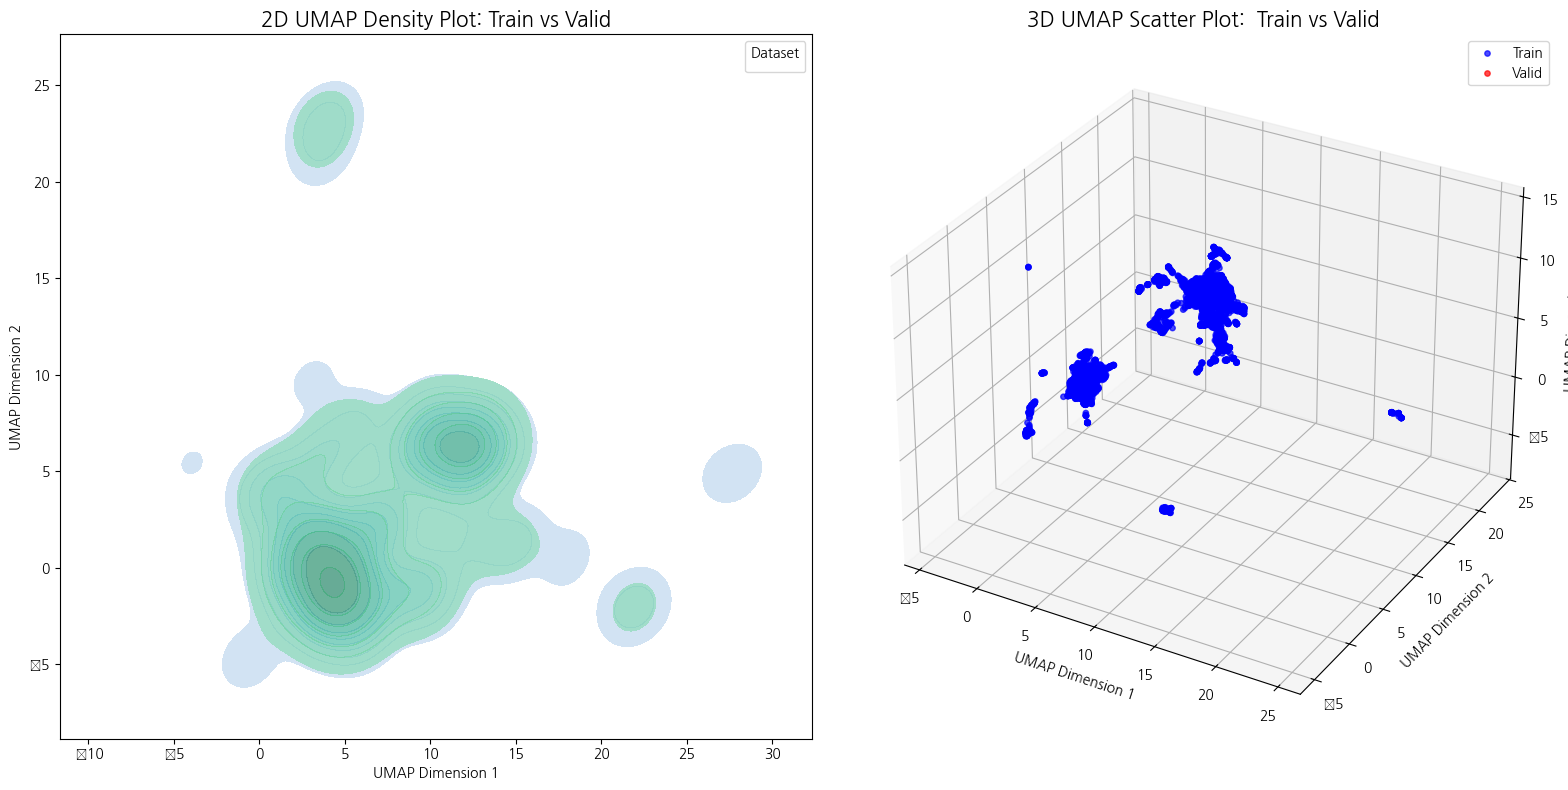

In [76]:
umap_density_plot(train_embeddings, valid_embeddings, label1="Train", label2="Valid")

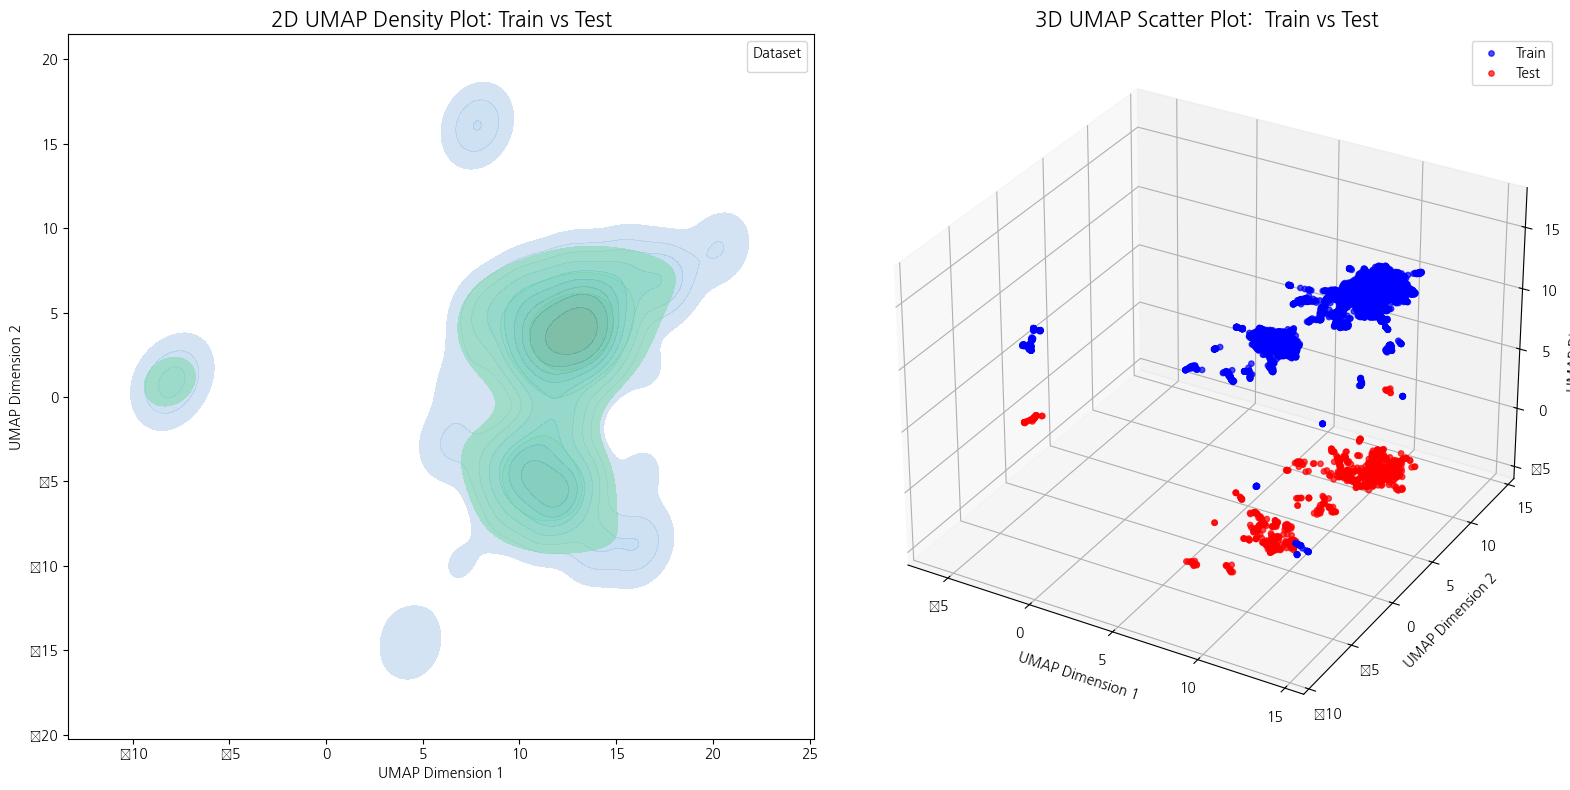

In [77]:
umap_density_plot(train_embeddings, test_embeddings, label1="Train", label2="Test")

## 5. Evidently AI

In [34]:
train['class'] = train['class'].astype('object')
valid['class'] = valid['class'].astype('object')
test['class'] = test['class'].astype('object')

In [35]:
from evidently import ColumnMapping

reference_df = pd.DataFrame(train_embeddings, 
                            columns=[f"dim_{i}" for i in range(train_embeddings.shape[1])])
current_df = pd.DataFrame(test_embeddings, 
                            columns=[f"dim_{i}" for i in range(test_embeddings.shape[1])])

column_mapping = ColumnMapping(
    embeddings={'small_subset': reference_df.columns[:100]}
)

In [36]:
from evidently.metrics import EmbeddingsDriftMetric
from evidently.report import Report
from evidently.metrics.data_drift.embedding_drift_methods import mmd

report = Report(metrics=[
    EmbeddingsDriftMetric('small_subset', 
                         drift_method = mmd(
                              threshold = 0.015,
                              bootstrap = None,
                              quantile_probability = 0.95,
                              pca_components = None,
                          )
    )
])

report.run(reference_data = reference_df, current_data = current_df, 
           column_mapping = column_mapping)
report

## 6. Alibi-Detect

In [87]:
from torch.utils.data import Dataset, DataLoader
from functools import partial

# load data
train = train[['class', 'text']]
valid = valid[['class', 'text']]
test = test[['class', 'text']]

# CustomDataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 'class'와 'text' 열을 각각 반환
        row = self.data.iloc[idx]
        return row['class'], row['text']  # 두 값을 반환

# DataLoader 생성 (collate_fn 없이)
data_loader = partial(
    DataLoader, shuffle=True, batch_size=100, num_workers=4
)

# Dataset 인스턴스 생성
ds_ref = CustomDataset(train)
ds_h0 = CustomDataset(valid)
ds_h1 = CustomDataset(test)

# DataLoader 생성
d1_ref = data_loader(ds_ref)
d1_h0 = data_loader(ds_h0)
d1_h1 = data_loader(ds_h1)

In [ ]:
from typing import List

'''
샘플 데이터를 추출해도 데이터 분포의 변화를 감지하는 데 충분히 유효한 결과를 얻을 수 있기 때문에 샘플링을 활용
'''

def update_flat_list(x: List[list]):
    return [item for sublist in x for item in sublist]

def accumulate_sample_no_target(dataloader: DataLoader, sample_size: int):
    batch_count = 0
    x_out, meta_out = [], []
    
    for batch in dataloader:
        # batch가 tuple인지 확인하고 처리
        if isinstance(batch, tuple) and len(batch) == 2:
            x, meta = batch
        else:
            # meta 정보가 없는 경우 처리
            x = batch  # batch 전체를 x로 간주
            meta = None

        n_batch = len(x)
        idx = min(sample_size - batch_count, n_batch)
        batch_count += n_batch

        # x 데이터를 슬라이싱하여 추가
        x_out += [x[:idx]]
        
        # meta가 dict일 때 처리, 없는 경우는 None
        if meta is not None and isinstance(meta, dict):
            meta_sliced = {key: value[:idx] if hasattr(value, '__getitem__') else value for key, value in meta.items()}
            meta_out.append(meta_sliced)
        else:
            meta_out.append(None)  # meta가 없을 경우 기본값 추가

        # 지정된 sample_size만큼 처리되면 중단
        if batch_count >= sample_size:
            break

    # x_out 리스트를 평탄화
    x_out = update_flat_list(x_out)
    return x_out, meta_out

# 예측 함수
labels = ['No!', 'Yes!']

def print_preds(preds: dict, preds_name: str) -> None:
    print(preds_name)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print('')

In [ ]:
from alibi_detect.cd.pytorch import preprocess_drift
from alibi_detect.models.pytorch import TransformerEmbedding # 모델의 특정 레이어에서 나온 임베딩을 효과적으로 추출하기 위한 목적으로 설계
from transformers import AutoTokenizer
from functools import partial

emb_type = 'hidden_state'  # 레이어 출력을 평균화해 문장 임베딩 생성
n_layers = 8
layers = [-_ for _ in range(1, n_layers + 1)]

embedding = TransformerEmbedding(model_name, emb_type, layers).to(device).eval()
preprocess_fn = partial(preprocess_drift, model=embedding, tokenizer=tokenizer, max_len=max_len, batch_size=32)

### 6.1 LSDD

In [ ]:
from alibi_detect.cd import LSDDDrift
    
def LSDDDrift_predictions(ref_size: int, test_size: int, n_sample: int) -> None:
    for _ in range(n_sample):
        # 데이터 샘플링
        x_ref, meta_ref = accumulate_sample_no_target(dl_ref, ref_size)
        x_h0, meta_h0 = accumulate_sample_no_target(dl_h0, test_size)
        x_h1, meta_h1 = accumulate_sample_no_target(dl_h1, test_size)
        
        # 드리프트 감지기 초기화 및 실행
        dd = LSDDDrift(x_ref, backend='pytorch', p_val=.05, 
                      preprocess_fn=preprocess_fn, 
                      n_permutations=1000)
        preds_h0 = dd.predict(x_h0)
        preds_h1 = dd.predict(x_h1)
        
        print_preds(preds_h0, 'H0')
        print_preds(preds_h1, 'H1')

In [62]:
LSDDDrift_predictions(ref_size=1000, test_size=1000, # 샘플 크기 임시 지정
                 n_sample=1)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.676

H1
Drift? No!
p-value: 0.192



### 6.2 MMD

In [65]:
from alibi_detect.cd import MMDDrift

def MMDDrift_predictions(ref_size: int, test_size: int, n_sample: int) -> None:
    for _ in range(n_sample):
        # 데이터 샘플링
        x_ref, meta_ref = accumulate_sample_no_target(dl_ref, ref_size)
        x_h0, meta_h0 = accumulate_sample_no_target(dl_h0, test_size)
        x_h1, meta_h1 = accumulate_sample_no_target(dl_h1, test_size)
        
        # 드리프트 감지기 초기화 및 실행
        dd = MMDDrift(x_ref, backend='pytorch', p_val=.05, 
                      preprocess_fn=preprocess_fn, 
                      n_permutations=1000)
        preds_h0 = dd.predict(x_h0)
        preds_h1 = dd.predict(x_h1)
        
        print_preds(preds_h0, 'H0')
        print_preds(preds_h1, 'H1')

In [66]:
MMDDrift_predictions(ref_size=1000, test_size=1000, # 샘플 크기 임시 지정
                 n_sample=1)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.966

H1
Drift? No!
p-value: 0.068



### 6.3 KS Test

In [101]:
from alibi_detect.cd.pytorch import UAE

# UAE 설정
input_layer = embedding  # embedding을 input_layer로 사용
#shape = (emb_batch.shape[1],)  # 임베딩 차원
enc_dim = 128  # 원하는 축소 차원

# UAE 인스턴스 생성
uae = UAE(input_layer=input_layer, shape=768, enc_dim=enc_dim).to(device)

In [102]:
from alibi_detect.cd import KSDrift
from alibi_detect.saving import save_detector, load_detector
from functools import partial
from alibi_detect.cd.pytorch import preprocess_drift

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=uae, tokenizer=tokenizer,
                        max_len=max_len, batch_size=32)

# DataLoader에서 데이터를 추출하는 함수
def extract_data_from_dataloader(dataloader):
    data = []
    for batch in dataloader:
        if isinstance(batch, tuple):
            facts, _ = batch  # facts만 추출
        else:
            facts = batch  # 단일 데이터로 처리
        data.extend(facts)
    return data

# 각 DataLoader에서 데이터 추출
X_ref = extract_data_from_dataloader(dl_ref)
X_h0 = extract_data_from_dataloader(dl_h0)
X_h1 = extract_data_from_dataloader(dl_h1)

# 데이터 크기 확인
print(f"X_ref length: {len(X_ref)}")
print(f"X_h0 length: {len(X_h0)}")
print(f"X_h1 length: {len(X_h1)}")

# initialize KSDrift detector for X_ref
cd = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_fn, input_shape=(max_len,))

# save/load detector
filepath = 'KStest_path'
save_detector(cd, filepath)
cd = load_detector(filepath)


X_ref length: 4078
X_h0 length: 1935
X_h1 length: 780


In [ ]:
print("--------valid--------")
preds_h0 = cd.predict(X_h0)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print('p-value: {}'.format(preds_h0['data']['p_val']))
print()

--------valid--------
Drift? No!
p-value: [0.42463568 0.55582637 0.7307974  0.08971866 0.5796328  0.35649294
 0.39547554 0.79867053 0.3960742  0.59299207 0.63336515 0.9926243
 0.309523   0.6177274  0.93666124 0.7773282  0.87529117 0.8952847
 0.9060738  0.5011373  0.7063285  0.83540326 0.36130863 0.8846039
 0.7829116  0.82892364 0.72961    0.91782004 0.22815125 0.7149823
 0.6180823  0.90353125 0.7750856  0.96425664 0.5225924  0.03580602
 0.23788285 0.49037907 0.33362725 0.19946018 0.7058919  0.9441424
 0.8723471  0.42357436 0.5208428  0.27282673 0.8824124  0.27911147
 0.72369    0.60893404 0.75170255 0.75107723 0.82271814 0.94347954
 0.9018555  0.24041672 0.86271757 0.8348575  0.72420627 0.38496912
 0.94696784 0.7183514  0.9888296  0.903997   0.14776973 0.6311531
 0.670987   0.55932087 0.6800294  0.2402586  0.01580707 0.10396655
 0.7578546  0.53920156 0.19162428 0.87318045 0.75290745 0.96478564
 0.65533644 0.51318175 0.36908585 0.7880694  0.81399715 0.4383803
 0.3036137  0.4614448  0.97

In [104]:
print("--------test--------")
preds_h0 = cd.predict(X_h1)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print('p-value: {}'.format(preds_h0['data']['p_val']))

--------test--------
Drift? No!
p-value: [0.6146987  0.2722111  0.7533671  0.6461131  0.2908809  0.29160967
 0.86197186 0.38225523 0.76777995 0.6615076  0.9900438  0.29297966
 0.09684663 0.5341325  0.26410678 0.8448975  0.43484458 0.28443357
 0.5356681  0.04829104 0.09618106 0.82197833 0.964388   0.55865216
 0.08913717 0.7518289  0.9843547  0.74479    0.5458331  0.27241948
 0.03257028 0.11205342 0.23488145 0.22390097 0.16043769 0.61724037
 0.04408299 0.62110966 0.06797063 0.7796712  0.5783337  0.10447329
 0.7837658  0.64057523 0.9041959  0.88202524 0.36819044 0.39817157
 0.07914877 0.05929132 0.9852866  0.92590296 0.12452831 0.77964586
 0.06819295 0.01903152 0.98504883 0.8885078  0.48677835 0.20566295
 0.37547308 0.919497   0.14839616 0.98704696 0.90765786 0.8626582
 0.8912799  0.40658414 0.8209342  0.4128763  0.39219245 0.39669403
 0.20540974 0.18558168 0.06776029 0.15618512 0.24055272 0.23747672
 0.5687736  0.45188907 0.5052131  0.0105846  0.97137946 0.37422067
 0.64464706 0.15623048